In [4]:
### install pyparsing==2.4.7 with sudo
import importlib
import blimpy
import h5py
import tensorflow as tf
import os
import re
import h5py
import numpy as np
import models
import utils
importlib.reload(models)
importlib.reload(utils)
from sklearn.svm import OneClassSVM
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
%load_ext autoreload
%autoreload 2

2022-12-03 17:35:08.165986: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-03 17:35:08.166021: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Introduction 
This project blah blah blah

## Data generation 

Data was generated using `insert_singals.py` command line tool. 1000 positive samples and 9000 negative samples were generated, to match the distribution of samples in the Kaggle Competetion. 

Data is normalized 

Data is further normalized when loaded in as X_test data.

File structure
```bash
data
- interesting 
    - h5
        - 0
            - frame_Off_1.h5
            - frame_Off_2.h5
            - frame_Off_3.h5
            - frame_On_1.h5
            - frame_On_2.h5
            - frame_On_3.h5
    - waterfall
        - 0.png
        ...
        - 999.png
- uninteresting
    - h5
    - waterfall
        - 0.png
        ...
        - 8999.png
    
```

## Machine-Learning
We decided to take 3 different approaches to this problem.

### Convolutional Neural Network

In [ ]:
train_generator, validation_generator, test_generator = utils.get_generators()

convolution_layers = [
    tf.keras.layers.Conv2D(filters=96, kernel_size=12, activation='relu', input_shape=(100,600,3)),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(filters=256, kernel_size=5, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(filters=384, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(filters=384, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(2,2)
]

dense_layers = [
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dropout(0.5)
]

cnn_model = models.CNN(convolution_layers, dense_layers, tf.keras.optimizers.Adam(), 10, 10, 5)
%time utils.train_eval(cnn_model, train_generator, validation_generator, test_generator)

Found 10000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Found 10000 images belonging to 2 classes.


2022-12-03 18:20:31.517999: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-03 18:20:31.521672: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-03 18:20:31.521752: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-12-03 18:20:31.521803: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-12-03 18:20:31.521855: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

Epoch 1/10


2022-12-03 18:20:37.445434: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2415559680 exceeds 10% of free system memory.
2022-12-03 18:20:40.593986: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1589575680 exceeds 10% of free system memory.
2022-12-03 18:21:04.259505: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1589575680 exceeds 10% of free system memory.


### Setting up h5 data

For our previous example, we used images as our input data. For our future methods, we will need set up our X_train appropriaretly. 

In [5]:
# TRy making size of array and using indexing 
data = np.zeros((len(os.listdir("data/training/interesting_h5/")) + len(os.listdir("data/training/uninteresting_h5/")), 1025))
data = utils.gather_files("data/training/interesting_h5/", "average", data, 1, 0)
data = utils.gather_files("data/training/uninteresting_h5/", "average", data, 0, len(os.listdir("data/training/interesting_h5/")))

In [6]:
ds_train = data
# np.random.shuffle(ds_train)

In [7]:
# TRy making size of array and using indexing 
data = np.zeros((len(os.listdir("data/validation/interesting_h5/")) + len(os.listdir("data/validation/uninteresting_h5/")), 1025))
data = utils.gather_files("data/validation/interesting_h5/", "average", data, 1, 0)
data = utils.gather_files("data/validation/uninteresting_h5/", "average", data, 0, len(os.listdir("data/validation/interesting_h5/")))

In [8]:
ds_val = data
np.random.shuffle(ds_val)

In [9]:
# TRy making size of array and using indexing 
data = np.zeros((len(os.listdir("data/test/interesting_h5/")) + len(os.listdir("data/test/uninteresting_h5/")), 1025))
data = utils.gather_files("data/test/interesting_h5/", "average", data, 1, 0)
data = utils.gather_files("data/test/uninteresting_h5/", "average", data, 0, len(os.listdir("data/test/interesting_h5/")))

In [10]:
ds_test = data
np.random.shuffle(ds_test)

## Supervised Learning

In [27]:
from sklearn.model_selection import GridSearchCV
paramaters = {"criterion": ('gini', 'entropy', 'log_loss'), "max_features":[1,5], "max_depth":[4,16], "n_estimators": [75,125]}
clf = GridSearchCV(RandomForestClassifier(), paramaters)
clf.fit(ds_val[:,0:-2], ds_val[:,-1])
print(clf.best_params_)


{'criterion': 'log_loss', 'max_depth': 16, 'max_features': 5, 'n_estimators': 125}


1.0

              precision    recall  f1-score   support

           0       0.97      0.92      0.95      9000
           1       0.51      0.72      0.60      1000

    accuracy                           0.90     10000
   macro avg       0.74      0.82      0.77     10000
weighted avg       0.92      0.90      0.91     10000

CPU times: user 5.93 s, sys: 0 ns, total: 5.93 s
Wall time: 5.93 s


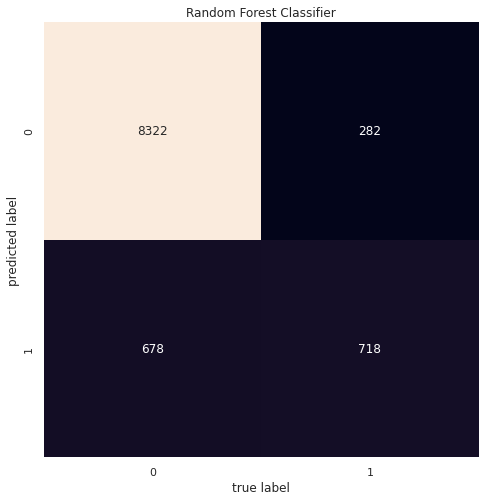

In [18]:
%matplotlib inline
random_forest_model = models.RF("log_loss", 125, 16, 5)
%time utils.train_eval(random_forest_model, ds_train, ds_val, ds_test)

## Anomoly Detection

### Isolation Forest

#### Contamination = 0.1

(10000, 1025)
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      9000
           1       0.09      0.09      0.09      1000

    accuracy                           0.82     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       0.82      0.82      0.82     10000

CPU times: user 6.96 s, sys: 162 ms, total: 7.12 s
Wall time: 7.14 s


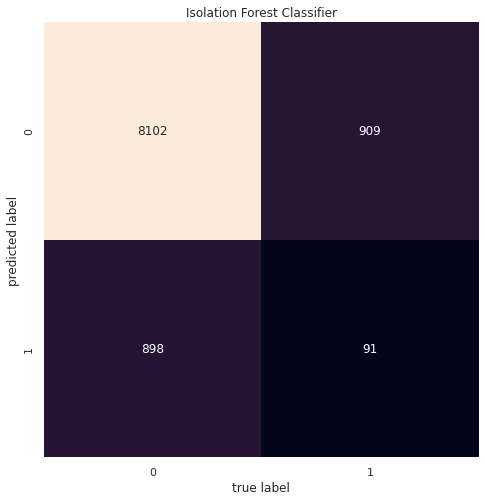

In [17]:
print(ds_train.shape)
contam_1 = ds_train[4500:-1, :]
isolation_forest_model = models.IF(10, 75, 0.1, False)
%time utils.train_eval(isolation_forest_model, contam_1, ds_val, ds_test)

#### Contamination = 0.25

#### Contamination = 0.5

In [45]:
from sklearn.metrics import make_scorer, f1_score
paramaters = {"max_samples": [1, 10], "bootstrap": (True, False),"n_estimators": [75,125], "contamination":[0.5]}
f1sc = make_scorer(f1_score, average='micro')
clf = GridSearchCV(IsolationForest(), paramaters, scoring=f1sc, refit=True)
g = lambda x: -1 if x == 1 else 0
y = list(map(g, ds_val[:, -1]))
clf.fit(ds_val[:,0:-2], y)
print(clf.best_params_)

{'bootstrap': False, 'contamination': 0.5, 'max_samples': 10, 'n_estimators': 75}


              precision    recall  f1-score   support

           0       0.90      0.50      0.64      9000
           1       0.10      0.47      0.16      1000

    accuracy                           0.50     10000
   macro avg       0.50      0.49      0.40     10000
weighted avg       0.82      0.50      0.59     10000

CPU times: user 10.3 s, sys: 832 ms, total: 11.1 s
Wall time: 11.1 s


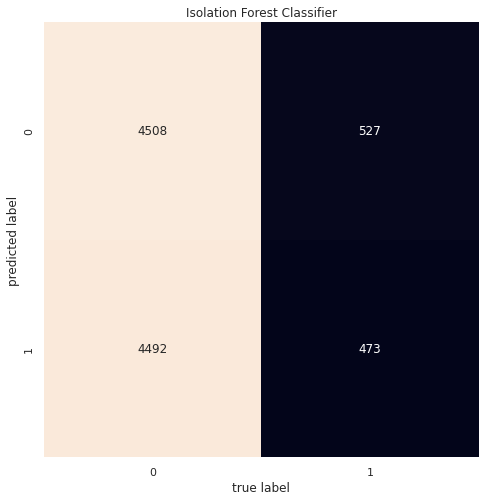

In [19]:
isolation_forest_model = models.IF(10, 75, 0.5, False)
%time utils.train_eval(isolation_forest_model, ds_train, ds_val, ds_test)

              precision    recall  f1-score   support

           0       0.91      0.54      0.68      9000
           1       0.11      0.53      0.19      1000

    accuracy                           0.54     10000
   macro avg       0.51      0.54      0.43     10000
weighted avg       0.83      0.54      0.63     10000

CPU times: user 1min 12s, sys: 0 ns, total: 1min 12s
Wall time: 1min 12s


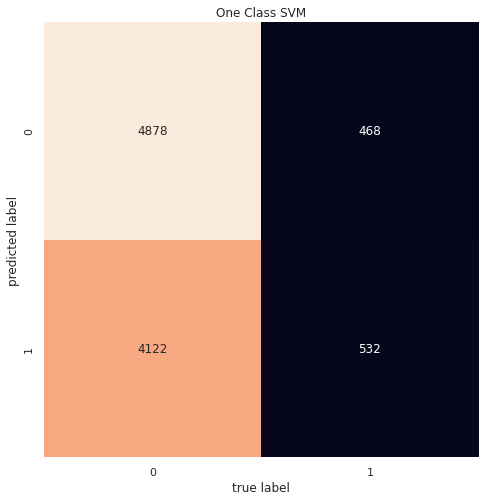

In [21]:
one_class_svm_model = models.OCSVM(kernel='rbf',gamma="scale",tol=1e-3)
%time utils.train_eval(one_class_svm_model, ds_train, ds_val, ds_test)